In [143]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sn
import statsmodels.api as sms
import matplotlib.pyplot as plt

plt.style.use('seaborn-muted')
# Selected with help from https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html


In [395]:
def calculate_summary_stats_from_agent_vars_dfs(df, warmup=30):
    # Operates on dataframe in place, adding columns of summary statistics
    # for the agent-level variables recorded in the agent_vars_by_tick column
    
    for dv in df['agent_vars_by_tick'][0].columns.tolist():
        for i, row in df.iterrows():
            summary = row['agent_vars_by_tick'][dv].unstack().describe().mean(axis=1)
            summary_post_warmup = row['agent_vars_by_tick'][dv].unstack()[warmup:].describe().mean(axis=1)
                
            for idx in summary.index:
                df.loc[i, dv + '_' + idx] = summary[idx]
                df.loc[i, dv + '_post_warmup_' + idx] = summary_post_warmup[idx]
                

In [471]:
def pearson_corr(df, iv, dv, verbose=True):
    pearson = df[[iv, dv]].corr()

    X_values = sms.add_constant(df[iv])
    regression_model = sms.OLS(df[dv], X_values).fit()
    print(regression_model.summary())
    
    
    return {'regr_model': regression_model, 'X_values': X_values, 'pearson': pearson}

In [396]:
files = [file for file in os.listdir('./data/runs') if 'pickles' not in file and '1' in file]
model_dataframes = {}

In [397]:
for file in files:
    
    try:

        f = open('./data/runs/' + file, 'rb')
        dfs = pickle.load(f)
        f.close()
        
        model_df = dfs['batch_model_df']
        calculate_summary_stats_from_agent_vars_dfs(model_df)

        model_dataframes[file.replace('.pkl', '')] = model_df
    
    except:
        print(file)

batch_run_1_record_freq.pkl


## Investigating effect of network size on dependent variables

### Effects on mining dynamics

In [56]:
num_sensors_model_df = dataframes['batch_run_1_num_sensors']['batch_model_df']

In [472]:
pearson_corr(num_sensors_model_df, 'num_sensors', 'mining_mean')


                            OLS Regression Results                            
Dep. Variable:            mining_mean   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     204.8
Date:                Fri, 09 Aug 2019   Prob (F-statistic):           3.00e-05
Time:                        10:43:19   Log-Likelihood:                -22.443
No. Observations:                   7   AIC:                             48.89
Df Residuals:                       5   BIC:                             48.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -5.1736      3.513     -1.473      

/Users/iv/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


{'regr_model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1c317a09e8>,
 'X_values':    const  num_sensors
 0    1.0           10
 1    1.0           20
 2    1.0           40
 3    1.0           80
 4    1.0          160
 5    1.0          320
 6    1.0          640,
 'pearson':              num_sensors  mining_mean
 num_sensors     1.000000     0.988012
 mining_mean     0.988012     1.000000}

In [144]:
pearson = num_sensors_model_df[['num_sensors', 'mining_mean']].corr()

X_values = sms.add_constant(num_sensors_model_df['num_sensors'])
regression_model = sms.OLS(num_sensors_model_df['mining_mean'], X_values).fit()
print(regression_model.summary())

                            OLS Regression Results                            
Dep. Variable:            mining_mean   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     204.8
Date:                Thu, 08 Aug 2019   Prob (F-statistic):           3.00e-05
Time:                        13:11:42   Log-Likelihood:                -22.443
No. Observations:                   7   AIC:                             48.89
Df Residuals:                       5   BIC:                             48.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -5.1736      3.513     -1.473      

/Users/iv/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


In [153]:
gradient = regression_model.params[1]
intercept = regression_model.params[0]
rsquared = regression_model.rsquared
pval = regression_model.f_pvalue

In [146]:
x_lobf = [num_sensors_model_df['num_sensors'].min(), num_sensors_model_df['num_sensors'].max()]
y_lobf = [x_lobf[0]*gradient + intercept, x_lobf[1]*gradient + intercept]


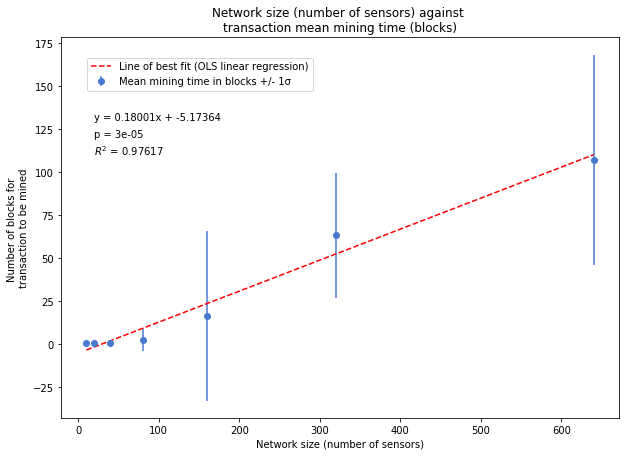

In [287]:
# Visualizing observations and OLS regression
plt.figure(figsize=(10,7))
plt.errorbar(num_sensors_model_df['num_sensors'], num_sensors_model_df['mining_mean'], yerr=num_sensors_model_df['mining_std'], fmt='o', label="Mean mining time in blocks +/- 1σ ")
plt.plot(x_lobf, y_lobf, 'r--', label="Line of best fit (OLS linear regression)" )
plt.legend(bbox_to_anchor=(0.46, 0.96))
plt.text(20, 130, "y = " + str(round(gradient, 5)) + 'x + ' + str(round(intercept, 5)))
plt.text(20,120,"p = " + str(round(pval, 5)))
plt.text(20,110,r"$R^2$ = " + str(round(rsquared, 5)))

# add Rsquared, MSE, p-value
_ = plt.xlabel('Network size (number of sensors)')
_ = plt.ylabel('Number of blocks for \ntransaction to be mined')
_ = plt.title("Network size (number of sensors) against \ntransaction mean mining time (blocks)")

In [ ]:
# Plot of residuals ... ?

In [182]:
# Deprecated
# plt.figure(figsize=(10,7))
# plt.plot(num_sensors_model_df['num_sensors'], num_sensors_model_df['mining_mean'], "bo", label="Mean number of blocks")
# plt.plot(x_lobf, y_lobf, 'r--')
# # plt.plot(np.log(num_sensors_model_df['num_sensors']), num_sensors_model_df['mining_mean-1std'], 'b.', label="+1 σ")
# # plt.plot(np.log(num_sensors_model_df['num_sensors']), num_sensors_model_df['mining_mean+1std'], 'b.', label="-1 σ")
# plt.legend(bbox_to_anchor=(1.05, 1))
# _ = plt.xlabel('Network size (number of sensors)')
# _ = plt.ylabel('Number of blocks for \ntransaction to be mined')
# plt.title("Network size by sensor count against \ntransaction mean mining time")

### Interpretation

A positive linear relationship (Pearson correlation coefficient: 0.98801) is observed between the number of sensors connecting to a blockchain and the mean mining time, measured in the number of blocks elapsed between when a transaction is submitted and when it is validated. 

Due to the limited sample size (n=7), along with constraints in the range of number of sensors swept, however, I hesitate to conclude firmly that this relationship is necessarily linear, and not a power or logarithmic relationship; further investigation is necessary. Regardless, it seems clear that increasing numbers of nodes connecting and submitting transactions to a blockchain network lengthens transaction validation times if all other factors are held constant, as hypothesized. This reaffirms the questions raised regarding the scalability of public blockchain networks for large, high transaction volume networks such as the Internet of Things. 

## Effects on informational currency

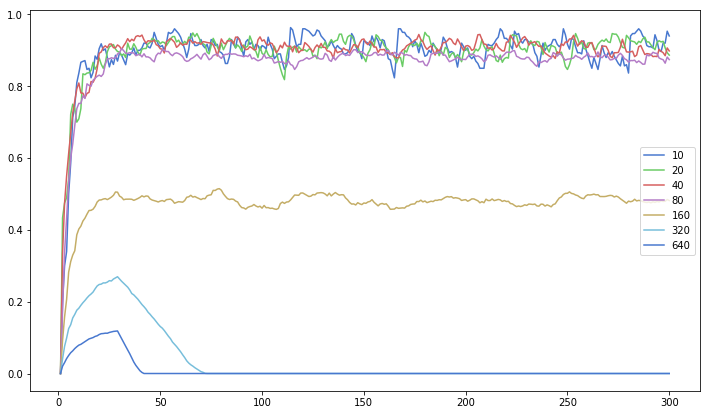

In [217]:
plt.figure(figsize=(12,7))
for i, run in num_sensors_model_df[['agent_vars_by_tick']].iterrows():
    plt.plot(run[0]['informational_currency'].unstack().mean(axis=1),label=num_sensors_model_df.loc[i, 'num_sensors'] )
    
plt.legend()
# num_sensors_model_df['agent_vars_by_tick']#[0].unstack()['informational_currency'].mean(axis=1).plot()

### Interpretation

#### Warm-up period

The expected warm-up period was observed clearly: after approximately 25-30 ticks (blocks were mined), a consistent level of informational currency was maintained, within a range of variability. 

*What explains the variability observed? Is that just stochasticity? Or because record_freq = 0.3, meaning sometimes edge nodes did not transmit, as they had not recorded any new data? Because transmit_freq = 1, they did attempt to transmit every tick.*


#### Large network behavior

The observed collapse of informational currency in the larger networks (x = {320, 640}) is likely due to the fixed window of 30 blocks used to calculate informational currency. Values of 0 indicate that no data collected by any sensor within the 30 most recent blocks had been reflected on the blockchain through the transaction submission and mining process. This is in line with the observed mean mining time of > 30 for both the 320- and 640-sensor networks.

This behavior means the 320- and 640-sensor networks will be excluded from the statistical analyses intended to identify the relationship between these two dimensions in the dataset. 

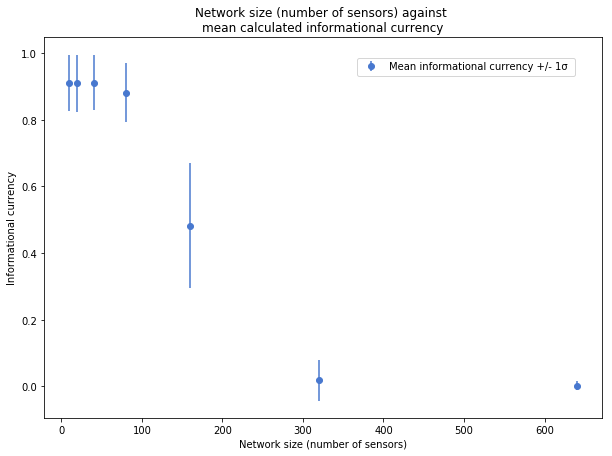

In [311]:
# Visualizing observations and OLS regression
plt.figure(figsize=(10,7))
plt.errorbar(num_sensors_model_df['num_sensors'], num_sensors_model_df['informational_currency_post_warmup_mean'], yerr=num_sensors_model_df['informational_currency_post_warmup_std'], fmt='o', label="Mean informational currency +/- 1σ ")
plt.legend(bbox_to_anchor=(0.96, 0.96))
# plt.text(20, 130, "y = " + str(round(gradient, 5)) + 'x + ' + str(round(intercept, 5)))
# plt.text(20,120,"p = " + str(round(pval, 5)))
# plt.text(20,110,r"$R^2$ = " + str(round(rsquared, 5)))

# add Rsquared, MSE, p-value
_ = plt.xlabel('Network size (number of sensors)')
_ = plt.ylabel('Informational currency')
_ = plt.title("Network size (number of sensors) against \nmean calculated informational currency")

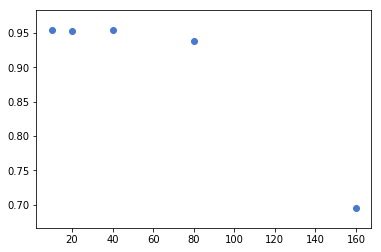

In [337]:
plt.scatter(num_sensors_model_df['num_sensors'][:5], num_sensors_model_df['informational_currency_post_warmup_mean'][:5])

#### Interpretation

A convex negative nonlinear relationship appears to exist between network size and the measure of informational currency employed here. While a negative relationship was hypothesized, the nonlinear nature was unexpected. Further modeling and statistical analysis is warranted to better understand the dynamics of how network size affects how well the state of the cloud ledger reflects the state at the edge. 

Why?

### Assessing stationarity: informational currency over time

In order to analyze temporal autocorrelation and seasonality in measures of informational currency over time (after the warm-up period), 

ACF plot
PACF plots
Augmented Dickey-Fuller test

In [436]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

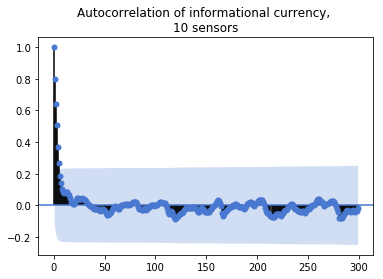

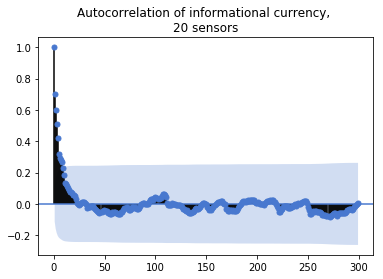

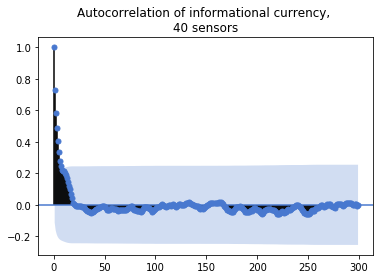

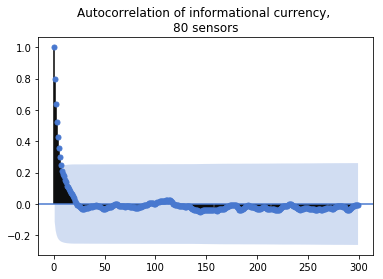

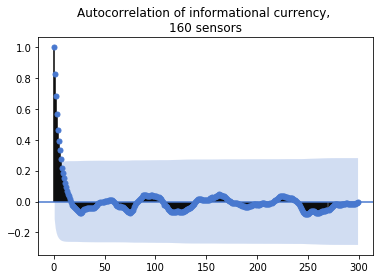

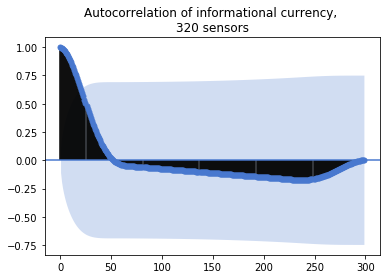

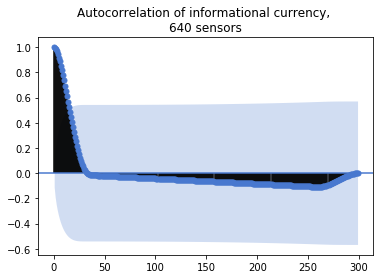

In [458]:
for i in range(len(num_sensors_model_df['agent_vars_by_tick'])):
    t = "Autocorrelation of informational currency, \n" + str(num_sensors_model_df.loc[i, 'num_sensors']) + " sensors"
    _ = plot_acf(num_sensors_model_df['agent_vars_by_tick'][i]['informational_currency'].unstack().mean(axis=1).values, title=t)

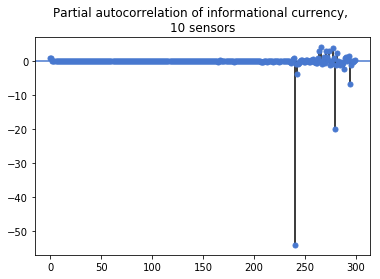

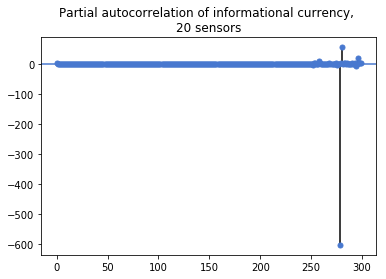

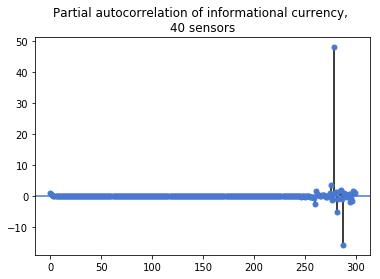

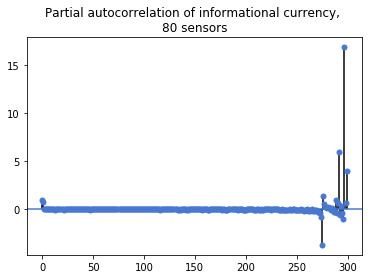

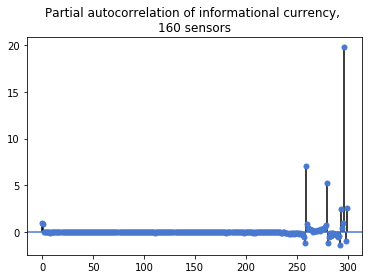

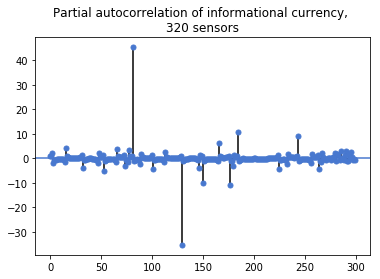

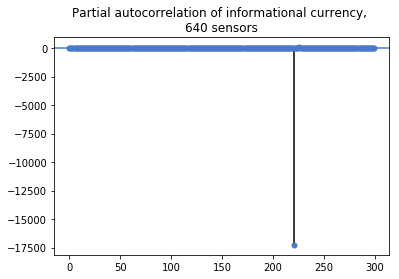

In [457]:
for i in range(len(num_sensors_model_df['agent_vars_by_tick'])):
    t = "Partial autocorrelation of informational currency, \n" + str(num_sensors_model_df.loc[i, 'num_sensors']) + " sensors"

    _ = plot_pacf(num_sensors_model_df['agent_vars_by_tick'][i]['informational_currency'].unstack().mean(axis=1).values, title=t)

In [460]:
# Adapted from CEGExxx: Spatial Temporal Data Analysis and Data Mining final project

from statsmodels.tsa.stattools import adfuller

for i in range(len(num_sensors_model_df['agent_vars_by_tick'])):

    adf_num_sensors = adfuller(num_sensors_model_df['agent_vars_by_tick'][i]['informational_currency'].unstack().mean(axis=1).values)
    print("Augmented Dickey-Fuller test, " + str(num_sensors_model_df.loc[i, 'num_sensors']) + " sensors")
    print('ADF Statistic: %f' % adf_num_sensors[0])
    print('p-value: %f' % adf_num_sensors[1])
    print('Critical Values:')
    for key, value in adf_num_sensors[4].items():
        print('\t%s: %.3f' % (key, value))
    print()

Augmented Dickey-Fuller test, 10 sensors
ADF Statistic: -10.913722
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 20 sensors
ADF Statistic: -18.998826
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 40 sensors
ADF Statistic: -9.933498
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 80 sensors
ADF Statistic: -11.053988
p-value: 0.000000
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 160 sensors
ADF Statistic: -5.210662
p-value: 0.000008
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 320 sensors
ADF Statistic: -6.370823
p-value: 0.000000
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572

Augmented Dickey-Fuller test, 640 sensors
ADF Statistic: -5.197354
p-value: 0.000009
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572



### Interpretation

The p-value of <0.05 on each of the Augmented Dickey-Fuller tests performed on the time series data representing informational currency serves as statistically significant evidence of what was visually observed in both the series plot and the autocorrelation function plot: the series do not have unit roots, and are stationary processes. This is important because it suggests that, with all other factors remaining constant, for a given transaction volume per block informational currency establishes a stable level. The variation was observed around that mean was based on stochasticity of transaction transmission: if a sensor did not transmit for an unusually long period, its informational currency level likely increased as transactions already submitted to the chain were validated, increasing the proportion reflected on chain of data recorded at the edge. The important observation is the stationarity of the metric: if blockchain transaction volume processing capacity adapts in response to submitted volumes, or submitted volumes are adjusted through incentivization adjustments (i.e. gas costs), sustainable operation of the blockchain appears possible, in this regard.

## Effects on gwei spent

Perhaps the primary constraint unique to public blockchains is the requirement that users pay for compute and storage space used. This is a necessary attribute of the system, designed to prevent intentional abuse or unintentional misuse, which seems to be inevitable in permissionless, anonymous systems. 



In [349]:
pearson_gwei = num_sensors_model_df[['num_sensors', 'gwei_spent_mean']].corr()

X_values_gwei = sms.add_constant(num_sensors_model_df['num_sensors'])
regression_model_gwei_spent = sms.OLS(num_sensors_model_df['gwei_spent_mean'], X_values_gwei).fit()
print(regression_model_gwei_spent.summary())

                            OLS Regression Results                            
Dep. Variable:        gwei_spent_mean   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     18.48
Date:                Thu, 08 Aug 2019   Prob (F-statistic):            0.00772
Time:                        16:59:34   Log-Likelihood:                -79.582
No. Observations:                   7   AIC:                             163.2
Df Residuals:                       5   BIC:                             163.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.125e+05   1.23e+04      9.128      

/Users/iv/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


In [350]:
gradient_gwei = regression_model_gwei_spent.params[1]
intercept_gwei = regression_model_gwei_spent.params[0]
rsquared_gwei = regression_model_gwei_spent.rsquared
pval_gwei = regression_model_gwei_spent.f_pvalue

In [351]:
x_lobf_gwei = [num_sensors_model_df['num_sensors'].min(), num_sensors_model_df['num_sensors'].max()]
y_lobf_gwei = [x_lobf_gwei[0] * gradient_gwei + intercept_gwei, x_lobf_gwei[1] * gradient_gwei + intercept_gwei]

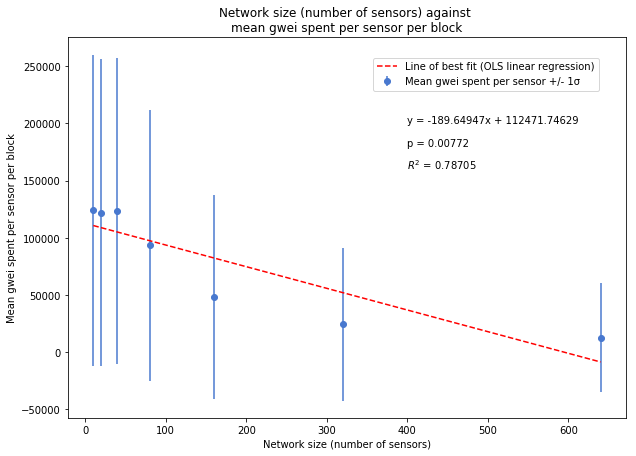

In [358]:

# Visualizing observations and OLS regression
plt.figure(figsize=(10,7))
plt.errorbar(num_sensors_model_df['num_sensors'], num_sensors_model_df['gwei_spent_mean'], yerr=num_sensors_model_df['gwei_spent_std'], fmt='o', label="Mean gwei spent per sensor +/- 1σ ")
plt.plot(x_lobf_gwei, y_lobf_gwei, 'r--', label="Line of best fit (OLS linear regression)" )
plt.legend(bbox_to_anchor=(0.96, 0.96))
plt.text(400, 200000, "y = " + str(round(gradient_gwei, 5)) + 'x + ' + str(round(intercept_gwei, 5)))
plt.text(400,180000,"p = " + str(round(pval_gwei, 5)))
plt.text(400,160000,r"$R^2$ = " + str(round(rsquared_gwei, 5)))

# add Rsquared, MSE, p-value
_ = plt.xlabel('Network size (number of sensors)')
_ = plt.ylabel('Mean gwei spent per sensor per block')
_ = plt.title("Network size (number of sensors) against \nmean gwei spent per sensor per block")

#### Interpretation 

An negative relationship is observed: as network size increases, average gwei spent per sensor per block decreases. This was expected given that each block has a fixed gas limit, here placing a limit on the amount of data that can be written to the blockchain each block validation - as the number of sensors attempting to submit data to be stored on chain increases, the likelihood of each sensor's transactions being validated, and contained data being written, decreases. Costs in gwei incurred are only deducted from the sensor's externally owned account upon transaction validation - the decrease in gwei spent relates closely to the decrease in informational currency observed.

While the p-value calculated for the line of best fit using OLS regression is below the 0.05 threshold set to accept significance, the non-normal distribution of residual errors suggests that a non-linear model may fit the data better. Further research into the nature of the relationship between network size (in effect, transaction volumes) and cost to each network participant is warranted. This is a point where deploying heterogeneous agents submitting transactions at differing frequencies and writing data of varying volumes could provide even further insight into network scalability. 

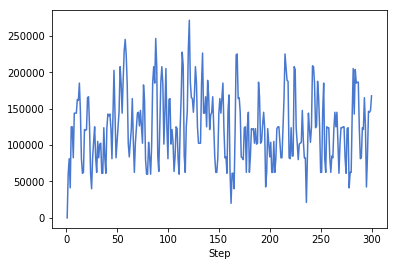

In [8]:
model_dfs['agent_vars_by_tick'][0].unstack()['gwei_spent'].mean(axis=1).plot()

In [9]:
dvs = ['gwei_spent', 'battery_life', 'data_collected', 'informational_currency']

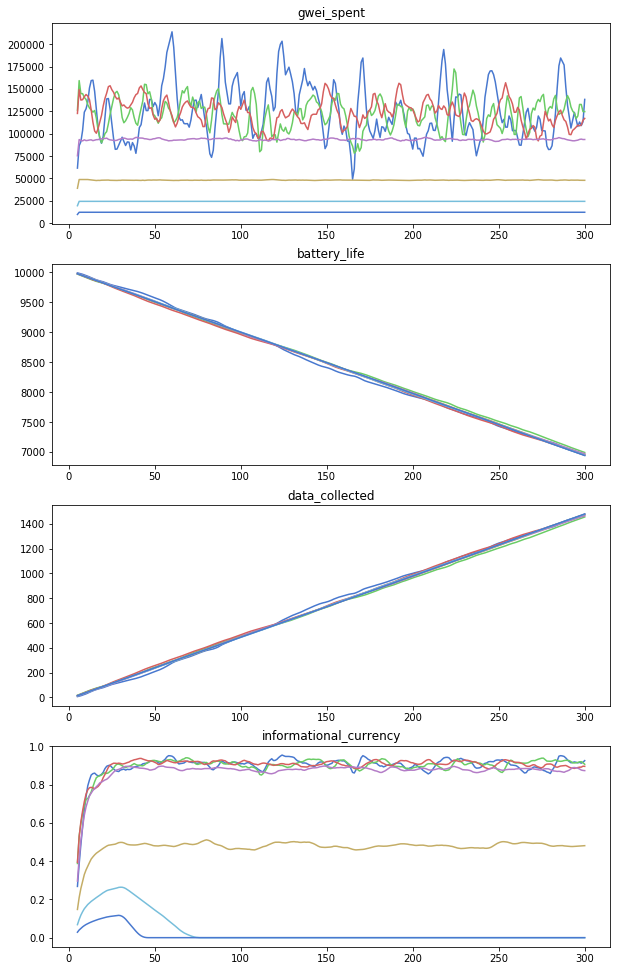

In [10]:
plt.figure(figsize=(10,17))
for i, dv in enumerate(dvs):
    plt.subplot(411 + i)
    plt.title(dv)
    for j, row in model_dfs.iterrows():
        plt.plot(row['agent_vars_by_tick'].unstack()[dv].mean(axis=1).rolling(5).mean(), label= str(row['record_freq']))


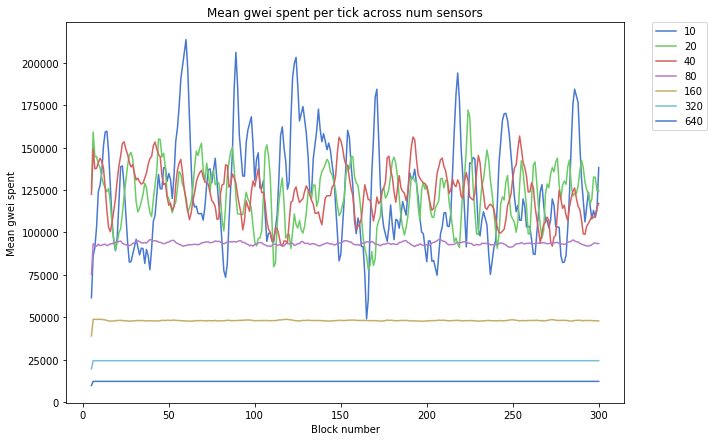

In [12]:
plt.figure(figsize=(10,7))
plt.title('Mean gwei spent per tick across num sensors')
for i, row in model_dfs.iterrows():
    plt.plot(row['agent_vars_by_tick'].unstack()['gwei_spent'].mean(axis=1).rolling(5).mean(), label= str(row['num_sensors']))

plt.ylabel('Mean gwei spent')
plt.xlabel('Block number')
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
# Examine descriptive statistics for each record frequency in a table

In [ ]:
# Examine correlation coefficients and say whether there is a trend

In [ ]:
# Calculate Z statistics to see if differences in distributions are statistically significant (they should be)

In [16]:
model_dfs

,num_sensors,Run,agent_vars_by_tick,mining_summary,model_vars_by_tick,blockchain_gas_price,block_gas_limit,gas_per_byte,gas_per_second,avg_block_time,...,record_freq,mining_count,mining_mean,mining_std,mining_min,mining_25%,mining_50%,mining_75%,mining_max,mining_frac_unmined
0,10,0,gwei_spent battery_life data_c...,count 1505.0 mean 1.0 ...,active_sensors 0 10 1 ...,20,8000000,625,75000000,13,...,0.3,1505.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,0.000000
1,20,1,gwei_spent battery_life data_c...,count 2999.000000 mean ...,active_sensors 0 20 1 ...,20,8000000,625,75000000,13,...,0.3,2999.0,1.003334,0.057658,1.0,1.0,1.0,1.0,2.0,0.000000
2,40,2,gwei_spent battery_life data_c...,count 6089.000000 mean ...,active_sensors 0 40 1 ...,20,8000000,625,75000000,13,...,0.3,6089.0,1.001807,0.042468,1.0,1.0,1.0,1.0,2.0,0.000000
3,80,3,gwei_spent battery_life data_c...,count 10397.000000 mean ...,active_sensors 0 80 1 ...,20,8000000,625,75000000,13,...,0.3,10397.0,2.318073,6.424294,1.0,1.0,1.0,1.0,45.0,0.140246
4,160,4,gwei_spent battery_life data_c...,count 11413.000000 mean ...,active_sensors 0 160 1 ...,20,8000000,625,75000000,13,...,0.3,11413.0,16.656182,49.331449,1.0,1.0,1.0,1.0,261.0,0.533115
5,320,5,gwei_spent battery_life data_c...,count 11661.000000 mean ...,active_sensors 0 320 1 ...,20,8000000,625,75000000,13,...,0.3,11661.0,63.296544,36.177128,2.0,31.0,63.0,94.0,125.0,0.761641
6,640,6,gwei_spent battery_life data_c...,count 11661.000000 mean ...,active_sensors 0 640 1 ...,20,8000000,625,75000000,13,...,0.3,11661.0,107.120573,61.072187,2.0,54.0,107.0,160.0,213.0,0.881090


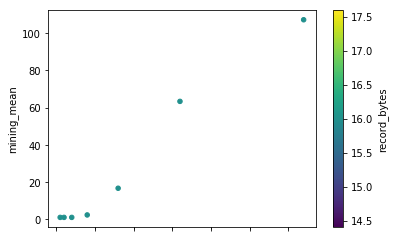

In [15]:
model_dfs.plot.scatter(x='num_sensors', y='mining_mean', c='info', cmap='viridis')

In [ ]:
plt.plot(model_dfs[''])

In [54]:
for rbytes in model_dfs['record_bytes'].unique():
    print(rbytes)

1
10
100


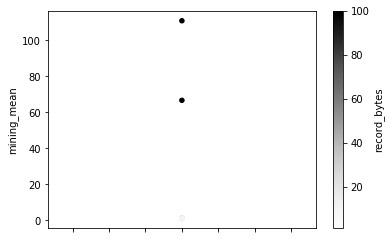

In [51]:
model_dfs[model_dfs['record_freq'] == 0.1].plot.scatter(x='record_freq', y='mining_mean', c='record_bytes')